Objectif : 
* Permettre une inférence par batch de SAM selon les deux modes : intéractif (depuis des prompts) et automatique (grille de prompt)
* Les modes seront codés en une même classe / fonction

On simplifiera l'inférence auto : 
* remove crops
* remove batch prompts `process_crops` 
* implement generator from SAM
* add processing mask (holes)  : 
	* add option
	* processing on low_res_mask or full masks

* Modify Sam model class or SamPredictor ?

In [1]:
from segment_any_change.utils import load_levircd_sample, show_img, load_img, flush_memory, load_sam
import numpy as np
from typing import Union
import pandas as pd
from copy import deepcopy
from typing import Tuple, Any, Dict, List, Union 

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from skimage import io

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from segment_any_change.sa_dev.modeling import Sam 
from segment_any_change.sa_dev.utils.transforms import ResizeLongestSide
from magic_pen.config import data_path, IMG_SIZE

In [3]:
from magic_pen.data.process import prepare_prompts, prepare_image

In [4]:
model_type = "vit_b"
sam = load_sam(model_type=model_type)

2024-05-17 09:14:07,642 - INFO ::  build SAM


In [5]:
""" Example 5: [LBK SAM] Batched Inputs -> **Some Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] """


' Example 5: [LBK SAM] Batched Inputs -> **Some Prompts** -> Multiple Mask Generation with filtering small and dulicated regions or holes [Very Hard] '

In [6]:
img1 = np.array(Image.open(f"{data_path}/demo/sam/sam1.png"))
img2 = np.array(Image.open(f"{data_path}/demo/sam//sam2.png"))

#### Prompts

In [7]:
# prompt
input_point = np.array([[200, 900], [150, 150], [100, 450], [600, 300], [370, 640], [800, 800]],  dtype=np.float32)
input_label = np.array([1, 1, 1, 1, 1, 1],  dtype=np.float32)

In [8]:
coords_torch, labels_torch, box_torch, mask_input_torch = prepare_prompts(input_point, input_label)

#### Image

In [9]:
def prepare_image2(image, img_resolution=1024):
    trans = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(1024),
                                            torchvision.transforms.Resize(img_resolution)])
    image = torch.as_tensor(image).cuda()
    return trans(image.permute(2, 0, 1))

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


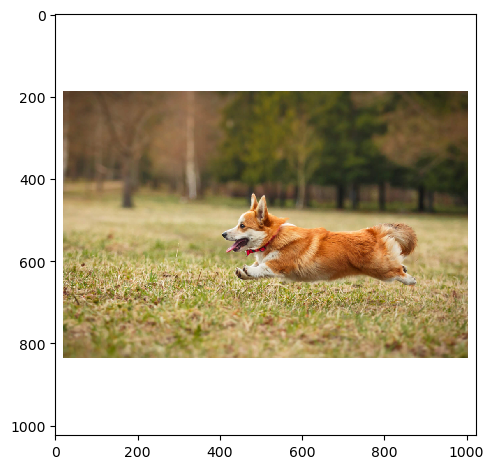

In [10]:
img1_tensor = prepare_image2(img1)
show_img(img1_tensor.permute(1, 2, 0).cpu().numpy(), show_axis=True)

In [11]:
img1[..., 1:].shape

(650, 984, 3)

/tmp/ipykernel_48573/4166607047.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) prepare_image.
  img1_tensor = prepare_image(img1[..., :-1])
/tmp/ipykernel_48573/4166607047.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) prepare_image.
  img2_tensor = prepare_image(img2[..., :-1])
2024-05-17 09:14:13,025 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


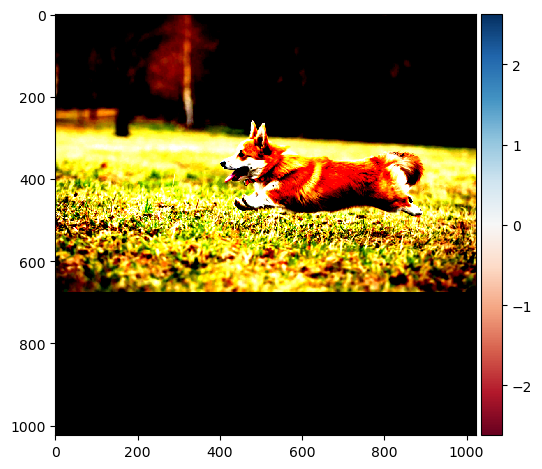

In [12]:
img1_tensor = prepare_image(img1[..., :-1])
img2_tensor = prepare_image(img2[..., :-1])
show_img(img1_tensor[0, ...].permute(1, 2, 0).cpu().numpy(), show_axis=True)

In [13]:
img1.shape, img1_tensor.shape

((650, 984, 4), torch.Size([1, 3, 1024, 1024]))

normalisation added

In [14]:
h, w = img1_tensor.shape[-2:]

padh = IMG_SIZE[0] - h
padw = IMG_SIZE[0] - w
x = F.pad(img1_tensor, (0, padw, 0, padh))

In [15]:
x.shape

torch.Size([1, 3, 1024, 1024])

In [16]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [17]:
img1_tensor.device

device(type='cpu')

In [18]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [19]:
torch.Tensor([123.675, 116.28, 103.53]).shape

torch.Size([3])

In [20]:
torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)

tensor([[[123.6750]],

        [[116.2800]],

        [[103.5300]]])

### Run batch

In [21]:
batched_input = [
     {
         'image': img1_tensor,
         'point_coords': coords_torch,
         'point_labels': labels_torch,
         'original_size': img1_tensor.shape[2:]
     },
     {
         'image': img2_tensor,
         'point_coords': coords_torch,
         'point_labels': labels_torch,
         'original_size': img2_tensor.shape[2:]
     }
]

In [22]:
img2_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [23]:
img1_tensor.shape

torch.Size([1, 3, 1024, 1024])

In [24]:
%%time
input_images = torch.stack(
[x["image"] for x in batched_input], dim=0
).view(-1, 3, 1024, 1024)

image_embeddings = sam.image_encoder(input_images)

CPU times: user 2min 38s, sys: 30.1 s, total: 3min 8s
Wall time: 3.94 s


In [25]:
%%time
refined_masks = sam.bforward(batched_input, multimask_output=True)

src shape : torch.Size([256, 64, 64])
out transformer
hs shape : torch.Size([1, 12, 256])
src shape : torch.Size([1, 4096, 256])
iou out shape : torch.Size([1, 256])
masks tokens out shape : torch.Size([1, 4, 256])
 hyper in shape : torch.Size([1, 4, 32])
src shape : torch.Size([256, 64, 64])
out transformer
hs shape : torch.Size([1, 12, 256])
src shape : torch.Size([1, 4096, 256])
iou out shape : torch.Size([1, 256])
masks tokens out shape : torch.Size([1, 4, 256])
 hyper in shape : torch.Size([1, 4, 32])
CPU times: user 2min 26s, sys: 16.9 s, total: 2min 43s
Wall time: 3.4 s


In [26]:
type(refined_masks)

list

In [27]:
len(refined_masks)

2

In [28]:
refined_masks[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

In [29]:
refined_masks[0]["masks"].shape

torch.Size([1, 3, 1024, 1024])

3 ???

### Dataset

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
# Ignore warnings
import warnings
from copy import deepcopy

warnings.filterwarnings("ignore")

/home/MDizier/miniforge3/envs/magic_pen/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from segment_any_change.utils import load_levircd_sample, show_img, load_img, flush_memory, load_sam

In [3]:
from magic_pen.data.process import DefaultTransform, generate_grid_prompt

In [4]:
from magic_pen.data.loader import load_ds, BiTemporalDataset, PromptDataset

from magic_pen.config import *
from segment_any_change.sa_dev.utils.transforms import ResizeLongestSide

In [5]:
df = load_ds(ds_name="levir-cd", data_type="train")

In [6]:
ds = BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)

In [7]:
sample = ds[12]

In [8]:
img_A, img_B, label  = sample.values()


In [9]:
dataloader = DataLoader(ds, batch_size=16)

In [10]:
len(dataloader)

28

In [11]:
for i_batch, sample_batched in enumerate(dataloader):

    # observe 4th batch and stop.
    if i_batch == 3:
        print(i_batch, sample_batched['img_A'].size(),
      sample_batched['label'].size())
        break

3 torch.Size([16, 3, 1024, 1024]) torch.Size([16, 1024, 1024])


In [12]:
ds_pt = PromptDataset(n_points=32, length=len(ds))

#### Run batch

In [13]:
model_type = "vit_b"
sam = load_sam(model_type=model_type)

2024-05-17 16:13:30,210 - INFO ::  build SAM


In [14]:
n_points= 32
batch_size = 2 # bitemporal => x2

ds = BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)

dataloader = DataLoader(ds, batch_size=batch_size)

results = []
grid = generate_grid_prompt(32)
                      
for i_batch, batch in enumerate(dataloader):
    if i_batch == 0:
        print(batch.keys())
        print(batch["img_A"].shape)
        batch["point_coords"] = deepcopy(grid)
        batch['original_size']: IMG_SIZE
        batch["image"] = torch.cat([batch["img_A"], batch["img_B"]], axis=0)
        break
        #results.append(sam.bforward(batch, multimask_output=True))

dict_keys(['img_A', 'img_B', 'label'])
torch.Size([2, 3, 1024, 1024])


In [15]:
len(results)

0

#### Inference batch loop

In [16]:
grid = generate_grid_prompt(16)
for i_batch, batch in enumerate(dataloader):
    print(batch.keys())
    print(batch["img_A"].shape)
    batch["point_coords"] = deepcopy(grid)
    batch['original_size']: IMG_SIZE
    batch["image"] = torch.cat([batch["img_A"], batch["img_B"]], axis=0)
    break

dict_keys(['img_A', 'img_B', 'label'])
torch.Size([2, 3, 1024, 1024])


#### Inference batch vectorized

In [17]:
n_points = 5
batch_points = np.tile(generate_grid_prompt(n_points), (batch_size*2, 1, 1))
batch_label = np.ones((batch_size*2, n_points*n_points))

In [18]:
coords_torch = torch.as_tensor(
batch_points, dtype=torch.float, device=DEVICE
)
labels_torch = torch.as_tensor(
    batch_label, dtype=torch.int, device=DEVICE
)   

In [19]:
coords_torch.shape, labels_torch.shape

(torch.Size([4, 25, 2]), torch.Size([4, 25]))

In [20]:
input_images = torch.cat([batch["img_A"], batch["img_B"]])

In [21]:
input_images = sam.preprocess(input_images)

In [22]:
input_images.shape

torch.Size([4, 3, 1024, 1024])

In [23]:
image_embeddings = sam.image_encoder(input_images)

In [24]:
image_embeddings.shape

torch.Size([4, 256, 64, 64])

In [25]:
# (coords_torch[:,:,None,:], labels_torch[...,None])
sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=(coords_torch[:,:,None,:], labels_torch[...,None]),
                boxes=None,
                masks=None,
            )

bs : 25
torch.Size([4, 25, 0, 256])
point shape raw torch.Size([4, 25, 1, 2])
padding_point shape raw torch.Size([4, 25, 1, 2])
concat points and padding shape torch.Size([4, 25, 2, 2])
emb points
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 0, 256])
torch.Size([4, 25, 2, 256])
torch.Size([4, 25, 2, 256])


Implementation doesn't allow batch inference for multi images and multi prompts in a vectorized manner

In [26]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

In [27]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

In [28]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([4, 25, 2, 256]), torch.Size([25, 256, 64, 64]))

It should have a dimension for each prompt ! =>256 pts and extra dim with padding

#### mask decoder inference loop

In [29]:
m =sam.prompt_encoder.get_dense_pe()

In [30]:
m.shape

torch.Size([1, 256, 64, 64])

#### mask decoder inference vectorized

In [31]:
print(image_embeddings.shape)
print((sam.prompt_encoder.get_dense_pe()).shape)
print(sparse_embeddings.shape)
print(dense_embeddings.shape)

torch.Size([4, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([4, 25, 2, 256])
torch.Size([25, 256, 64, 64])


In [34]:
low_res_masks, iou_predictions = sam.mask_decoder.predict_masks(
    image_embeddings=image_embeddings,
    image_pe=sam.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    #multimask_output=True,
)

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([4, 25, 5, 256])
tokens shape : torch.Size([4, 25, 7, 256])
img_embedding (src) : torch.Size([4, 256, 64, 64])
src first interleave shape : torch.Size([4, 25, 256, 64, 64])
src shape : torch.Size([4, 25, 256, 64, 64])
src dense_prompt_embeddings : torch.Size([25, 256, 64, 64])
expanded
--in transformer--
src : torch.Size([4, 25, 256, 64, 64])
pos_src : torch.Size([4, 25, 256, 64, 64])
tokens : torch.Size([4, 25, 7, 256])
out transformer
hs shape : torch.Size([100, 7, 256])
src shape : torch.Size([100, 4096, 256])
iou out shape : torch.Size([100, 256])
masks tokens out shape : torch.Size([100, 4, 256])
upscaled src tokens out shape : torch.Size([100, 32, 256, 256])
torch.Size([100, 32])
torch.Size([100, 4, 32])
 mask_low : torch.Size([100, 4, 65536])


In [74]:
masks = low_res_masks.view(100, -1, 256, 256)

In [75]:
print(masks.shape)
mask_slice = slice(1, None)
masks = masks[:, mask_slice, :, :]

torch.Size([100, 4, 256, 256])


In [76]:
masks.shape

torch.Size([100, 3, 256, 256])

In [77]:
masks = masks.view(4, 25, 3, 256, 256).permute(0, 1, 3, 4, 2).cpu().detach().numpy()

In [79]:
masks.shape

(4, 25, 256, 256, 3)

In [83]:
masks_img_1 = np.sum(masks[0], axis=0)
masks_img_2 = np.sum(masks[1], axis=0)

In [87]:
masks_img_1.shape

(256, 256, 3)

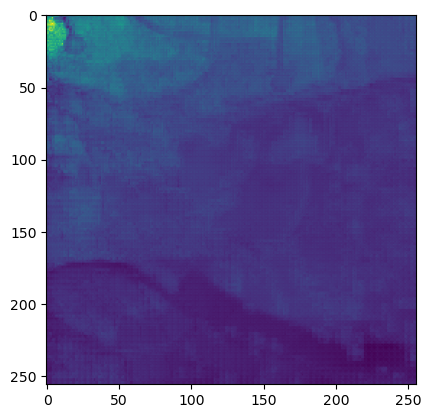

In [88]:
plt.imshow(masks_img_1[...,0])

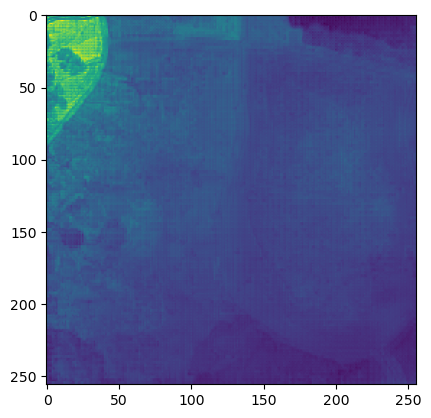

In [89]:
plt.imshow(masks_img_2[...,0])

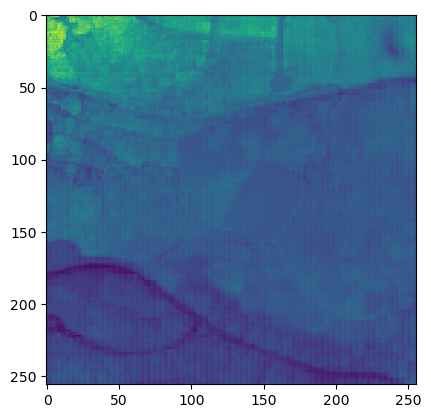

In [72]:
plt.imshow(masks[0])

In [65]:
masks[0, :, :, :].cpu().detach().numpy().transpose(1, 2, 0)[0].shape

(256, 3)

In [ ]:
np.sqrt(8192)

In [ ]:
from torch import nn
from segment_any_change.sa_dev.modeling.common import LayerNorm2d

transformer_dim = 256
layer =  nn.ConvTranspose2d(
        transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
    )
output_upscaling = nn.Sequential(
    nn.ConvTranspose2d(
        transformer_dim, transformer_dim // 4, kernel_size=2, stride=2
    ),
    LayerNorm2d(transformer_dim // 4),
    nn.ConvTranspose2d(
        transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2
    ),
)

In [ ]:
src = torch.as_tensor(
    np.random.random((100, 256, 64, 64)), device=DEVICE, dtype=torch.float32
)

In [47]:
out = layer(src)

In [48]:
out.shape

torch.Size([100, 64, 128, 128])

In [55]:
b, c, h, w = src.shape
n = 25
output_upscaling(src).view(b, -1, h * w).view(b, n, -1, h, w)

RuntimeError: shape '[100, 25, -1, 64, 64]' is invalid for input of size 209715200

## Test transformer

In [16]:
# src : torch.Size([64, 256, 64, 64])
# pos_src : torch.Size([64, 256, 64, 64])
# tokens : torch.Size([64, 7, 256])

src = torch.as_tensor(
    np.random.random((4, 64, 256, 64, 64)), device=DEVICE, dtype=torch.float32
)
pos_src = torch.as_tensor(
    np.random.random((4, 64, 256, 64, 64)), device=DEVICE,  dtype=torch.float32
)
tokens = torch.as_tensor(
    np.random.random((4, 64, 7, 256)), device=DEVICE,  dtype=torch.float32
)

In [17]:
src[0].flatten(2).permute(0, 2, 1).shape

torch.Size([64, 4096, 256])

In [18]:
pos_src.flatten(0, 1).flatten(2).permute(0, 2, 1).shape

torch.Size([256, 4096, 256])

In [19]:
src.flatten(0, 1).flatten(2).shape

torch.Size([256, 256, 4096])

In [21]:
b, n, c, h, w = src.shape

hs, src  = sam.mask_decoder.transformer(
    src, pos_src, tokens
)

In [22]:
hs.shape

torch.Size([256, 7, 256])

In [23]:
src.shape

torch.Size([256, 4096, 256])

In [25]:
src.transpose(1, 2).view(b,n, c, h, w).shape

torch.Size([4, 64, 256, 64, 64])

In [33]:
64*64

4096

In [53]:
src = torch.as_tensor(
    np.random.random((16, 256, 64, 64)), device=DEVICE
)

In [58]:
def interpolate(x, w, h):
    from torch import nn
    height, width = x.shape[2:]

    # we add a small number to avoid floating point error in the interpolation
    # see discussion at https://github.com/facebookresearch/dino/issues/8
    w0, h0 = w + 0.1, h + 0.1
    x = nn.functional.interpolate(
        x,
        scale_factor=(w0 / height, h0 / width),
        mode='bicubic',
    )
    return x

In [62]:
src.shape

torch.Size([16, 256, 64, 64])

In [61]:
dense_embeddings.shape

torch.Size([4, 256, 64, 64])

In [67]:
sparse_embeddings.shape

torch.Size([4, 26, 256])

In [70]:
dense_embeddings.expand(
            src.size(0), -1, -1, -1
        )

RuntimeError: The expanded size of the tensor (16) must match the existing size (4) at non-singleton dimension 0.  Target sizes: [16, -1, -1, -1].  Tensor sizes: [4, 256, 64, 64]

In [72]:
torch.repeat_interleave(dense_embeddings, src.shape[0] // dense_embeddings.shape[0], dim=0).shape

torch.Size([16, 256, 64, 64])

In [59]:
src + torch.repeat_nterkeae(dense_embeddings, *src.shape[2:])

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [131]:
low_res_masks.shape

torch.Size([4, 3, 256, 256])

In [93]:
masks = sam.postprocess_masks(
                low_res_masks,
                input_size=IMG_SIZE,
                original_size=IMG_SIZE,
            )

In [94]:
masks = masks.cpu().detach().numpy()

In [95]:
masks.shape

(4, 3, 1024, 1024)

Wrong dimensions : il faut

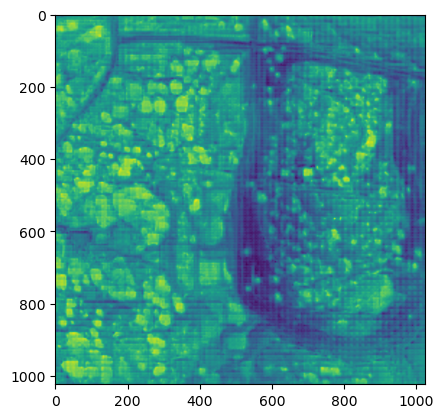

In [96]:
plt.imshow(masks[1][2])

In [83]:
masks = masks.reshape((4, 1024, -1))

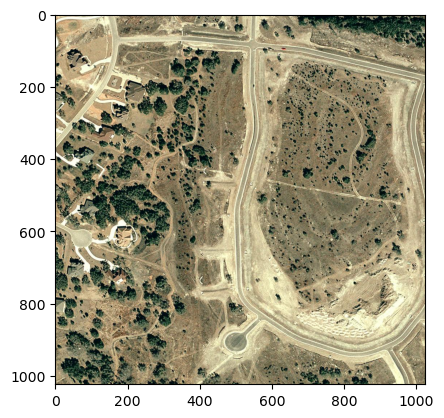

In [85]:
plt.imshow(batch["img_A"][1].permute(1, 2, 0))

In [ ]:
torch.cat([batch["img_A"], batch["img_B"]], axis=0).shape

In [38]:
src = torch.repeat_interleave(image_embeddings[0,...], 2, dim=0)


In [39]:
src.shape

torch.Size([512, 64, 64])

In [35]:
res = interpolate(dense_embeddings, *src.shape[2:])
res.shape

torch.Size([2, 256, 64, 64])

In [40]:
src + dense_embeddings

RuntimeError: The size of tensor a (512) must match the size of tensor b (256) at non-singleton dimension 1

In [33]:
img1_tensor.ndim

4

### Transform

In [21]:
long_side_length = 1024
oldh = 1050
oldw = 1100

In [22]:
scale = long_side_length * 1.0 / max(oldh, oldw)
newh, neww = oldh * scale, oldw * scale
print(newh)
print(neww)

977.4545454545455
1024.0


### decoder token dimensions

In [73]:
iou_token = nn.Embedding(1, 256)
mask_tokens = nn.Embedding(3, 256)

In [74]:
mask_tokens.weight.shape

torch.Size([3, 256])

In [75]:
# Concatenate output tokens
output_tokens = torch.cat([iou_token.weight, mask_tokens.weight], dim=0)
print(output_tokens.shape)
output_tokens = output_tokens.unsqueeze(0).expand(sparse_embeddings.size(0), -1, -1)
print(output_tokens.shape)
tokens = torch.cat((output_tokens, sparse_embeddings), dim=1)
print(tokens.shape)

torch.Size([4, 256])
torch.Size([4, 4, 256])
torch.Size([4, 1029, 256])


In [81]:
# Expand per-image data in batch direction to be per-mask
src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
src.shape

torch.Size([16, 256, 64, 64])

In [79]:
# Expand per-image data in batch direction to be per-mask
src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
src = src + dense_embeddings

pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 0

In [77]:
torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0).shape

torch.Size([16, 256, 64, 64])

In [ ]:
torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)

In [ ]:
def show_masks(masks, plt, alpha=0.7):
    if len(masks) == 0: return
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((masks[0]['segmentation'].shape[0], masks[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_masks:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
    ax.imshow(img)
    return img

def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)   
    
    
# image mask generation visualization
for i, mask in enumerate(refined_masks[0]):
    plt.figure(figsize=(5,5))
    plt.imshow(img1_tensor.permute(1,2,0).cpu().numpy())
    show_mask(mask.cpu().numpy(), plt.gca())
    # show_box(input_box, plt.gca(), plt)
    show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
    plt.title(f"LBK Refined Mask {i+1}", fontsize=18)
    plt.axis('on')
    plt.show()


In [ ]:

for i, mask in enumerate(refined_masks[1]):
    plt.figure(figsize=(5,5))
    plt.imshow(img2_tensor.permute(1,2,0).cpu().numpy())
    show_mask(mask.cpu().numpy(), plt.gca())
    # show_box(input_box, plt.gca(), plt)
    show_points(input_point.cpu().numpy(), input_label.cpu().numpy(), plt.gca())
    plt.title(f"LBK Refined Mask {i+1}", fontsize=18)
    plt.axis('on')
    plt.show()
